In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [3]:
jan2023 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
feb2023 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [4]:
jan2023

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


### Q1 Downloading the data.
How many columns are there? 19

In [5]:
jan2023.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [6]:
jan2023.tpep_pickup_datetime = pd.to_datetime(jan2023.tpep_pickup_datetime)
jan2023.tpep_dropoff_datetime = pd.to_datetime(jan2023.tpep_dropoff_datetime)

jan2023['duration_in_secs'] = (jan2023.tpep_dropoff_datetime - jan2023.tpep_pickup_datetime)
jan2023['duration'] = jan2023.duration_in_secs.apply(lambda x: x.total_seconds() / 60)

np.std(jan2023['duration'])

np.float64(42.59434429744777)

In [7]:
jan2023['duration'] = (jan2023.tpep_dropoff_datetime - jan2023.tpep_pickup_datetime).dt.seconds.div(60)

In [8]:
np.std(jan2023.duration)

np.float64(41.62918432251384)

### Q2. Computing duration: 
What's the standard deviation of the trips duration in January?  __42.59__ or with other method 41.62.

count    3.066766e+06
mean     1.565303e+01
std      4.162919e+01
min      0.000000e+00
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.439800e+03
Name: duration, dtype: float64

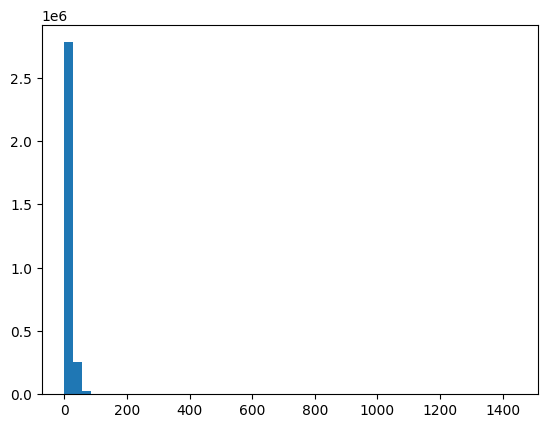

In [9]:
plt.hist(jan2023['duration'], bins=50)
jan2023.duration.describe(percentiles=[0.95, 0.98, 0.99])

In [10]:
before_filter = jan2023.shape[0]
print('Number of samples before filtering: ', before_filter)
jan2023 = jan2023[(jan2023.duration >= 1) & (jan2023.duration <= 60)]
after_filter = jan2023.shape[0]
print('Number of samples after filtering: ', after_filter)

Number of samples before filtering:  3066766
Number of samples after filtering:  3009176


In [11]:
#percent of values after filtering
round(after_filter / before_filter, 4)

0.9812

### Q3. Dropping outliers
What fraction of the records left after you dropped the outliers? __0.9891__ i.e. 98%

In [12]:
features = ['DOLocationID', 'PULocationID']
response = ['duration']

In [13]:
jan2023.shape

(3009176, 21)

In [14]:
jan2023.loc[:, features] = jan2023.loc[:, features].astype(str)

/tmp/ipykernel_90225/1507643611.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['141' '237' '238' ... '239' '79' '143']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jan2023.loc[:, features] = jan2023.loc[:, features].astype(str)
/tmp/ipykernel_90225/1507643611.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['161' '43' '48' ... '114' '230' '262']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jan2023.loc[:, features] = jan2023.loc[:, features].astype(str)


In [15]:
jan2023.dtypes

VendorID                           int64
tpep_pickup_datetime      datetime64[us]
tpep_dropoff_datetime     datetime64[us]
passenger_count                  float64
trip_distance                    float64
RatecodeID                       float64
store_and_fwd_flag                object
PULocationID                      object
DOLocationID                      object
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
congestion_surcharge             float64
airport_fee                      float64
duration_in_secs         timedelta64[us]
duration                         float64
dtype: object

In [16]:
train = jan2023.loc[:, features]

In [17]:
train_dict = train.to_dict(orient='records')

### Q4. One-hot encoding

What's the dimensionality of this matrix (number of columns)? __2__. Not too sure of this answer. I think it is because we only should include the two features for vectorization.

In [18]:
y_train = jan2023.duration
y_train

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3009176, dtype: float64

In [19]:
dv = DictVectorizer()

X_train = dv.fit_transform(train_dict)

In [20]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [21]:
root_mean_squared_error(y_train, y_pred)

7.649261254600018

### Q5. Training a model
What's the RMSE on train? __7.64__

In [22]:
def prepare_df(df, features=['DOLocationID', 'PULocationID'], response='duration'):
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

    df['duration_in_secs'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime)
    df['duration'] = df.duration_in_secs.apply(lambda x: x.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    df.loc[:, features] = df.loc[:, features].astype(str)

    response = df[response].values

    return df, response

In [23]:
val_df, y_val = prepare_df(feb2023)

/tmp/ipykernel_90225/3898415426.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['163' '26' '145' ... '143' '162' '140']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, features] = df.loc[:, features].astype(str)
/tmp/ipykernel_90225/3898415426.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['142' '132' '161' ... '158' '79' '161']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, features] = df.loc[:, features].astype(str)


In [24]:
val_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration_in_secs,duration
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,...,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,0 days 00:01:41,1.683333
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,...,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,0 days 00:32:05,32.083333
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,...,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,0 days 00:13:18,13.300000
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,...,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,0 days 00:14:38,14.633333
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,...,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,0 days 00:27:57,27.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913950,2,2023-02-28 23:46:00,2023-03-01 00:05:00,NaN,4.65,NaN,None,249,140,0,...,0.00,0.5,4.84,0.0,1.0,29.06,NaN,NaN,0 days 00:19:00,19.000000
2913951,2,2023-02-28 23:26:02,2023-02-28 23:37:10,NaN,2.47,NaN,None,186,79,0,...,0.00,0.5,2.65,0.0,1.0,20.31,NaN,NaN,0 days 00:11:08,11.133333
2913952,2,2023-02-28 23:24:00,2023-02-28 23:38:00,NaN,3.49,NaN,None,158,143,0,...,0.00,0.5,0.00,0.0,1.0,21.64,NaN,NaN,0 days 00:14:00,14.000000
2913953,2,2023-02-28 23:03:00,2023-02-28 23:10:00,NaN,2.13,NaN,None,79,162,0,...,0.00,0.5,2.63,0.0,1.0,20.19,NaN,NaN,0 days 00:07:00,7.000000


In [25]:
y_val

array([ 1.68333333, 32.08333333, 13.3       , ..., 14.        ,
        7.        ,  9.8       ], shape=(2855951,))

In [26]:
val_dict = val_df[features].to_dict(orient='records')

In [27]:
val_dict[:10]

[{'DOLocationID': '163', 'PULocationID': '142'},
 {'DOLocationID': '26', 'PULocationID': '132'},
 {'DOLocationID': '145', 'PULocationID': '161'},
 {'DOLocationID': '236', 'PULocationID': '148'},
 {'DOLocationID': '244', 'PULocationID': '137'},
 {'DOLocationID': '141', 'PULocationID': '263'},
 {'DOLocationID': '243', 'PULocationID': '48'},
 {'DOLocationID': '211', 'PULocationID': '114'},
 {'DOLocationID': '249', 'PULocationID': '114'},
 {'DOLocationID': '107', 'PULocationID': '125'}]

In [28]:
X_val = dv.transform(val_dict)

y_pred = lr.predict(X_val)

In [29]:
root_mean_squared_error(y_pred, y_val)

7.811813468409544

### Q6. Evaluating the model
What's the RMSE on validation? __7.81__